### Calibrate Analog Mic using the Tympan

Note: If using WSL to run Python in a virtual Linux environment, then you will need to attach the USB serial port to allow access from WSL.  
Follow: https://learn.microsoft.com/en-us/windows/wsl/connect-usb
- To list: usbipd list
- To bind: usbipd bind --busid <port #>
- To attach: usbipd attach --wsl --busid <port#>
- To detach: usbipd detach --busid <port #>

In [78]:
%matplotlib widget

# Import dependencies
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import numpy as np


In [80]:

# Local imports (may take 60sec to load)
from auren.core.calibrate import Calibrate
import auren.core.data_models as odm

In [3]:
# Local imports (may take 60sec to load)
from auren.core.calibrate import Calibrate
import auren.core.data_models as odm

In [77]:
cal = Calibrate(out_path='./calibrate_analog_mic')

In [82]:
# Connect to the tympan (if running in a virtual environment (WSL), first attach the port with usbipd attach --wsl --busid 1-8)
cal.connect()

Opened:  /dev/ttyACM0


Exception in thread Thread-323 (read_rx_thread):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/mnt/c/Users/eyuan/Documents/GitLab/open-hearing-hardware/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/eyuan/Documents/GitLab/open-hearing-hardware/auren/auren/core/tympan_serial.py", line 236, in read_rx_thread
    if self.port_h.in_waiting > 0:
  File "/mnt/c/Users/eyuan/Documents/GitLab/open-hearing-hardware/.venv/lib/python3.10/site-packages/serial/serialposix.py", line 549, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 5] Input/output error


In [ ]:
# Record 94dBSPL
fname_bk94 = cal.calibrateAnalogMic()
print(fname_bk94)

No Crash Data To Report
  Hopefully all is well, but certain types of crashes can't be reported:
	stuck in an infinite loop (technically, hardware still running properly)
	remaining in a low power sleep mode
	access to certain peripherals without their clock enabled (eg, FlexIO)
	change of CPU or bus clock speed without use of glitchless mux
DigMicProbeTest: setup():...
Sample Rate (Hz): 96000.00
Audio Block Size (samples): 128
SD configured for 4 channels.
Setup: complete.
SerialManager Help: Available Commands:
 General: No Prefix
   h    : Print this help
   w/W/e/E/o: INPUT  : Switch to the PCB Mics / Pink Jack - Mic Bias / Pink Jack Line in / Digital mics / Hybrid
   k/K  : CHIRP  : Incr/decrease loudness of chirp (cur = 0.0 dBFS)
   d/D  : CHIRP  : Incr/decrease duration of chirp (cur = 5.0 sec)
   n    : CHIRP  : Start the chirp
   1-3  : SDPlay : Play files 1-3 from SD Card
   q    : SDPlay : Stop any currently plying SD files
   b    : AutoWrite : Start chirp and SD recording 

In [ ]:
# Record 114dBSPL
fname_bk114 = cal.calibrateAnalogMic()
print(fname_bk114)


AttributeError: 'NoneType' object has no attribute 'send_char'

In [84]:
# Place files in ./calibrate_analog_mic
cal.connect_sd()

In [158]:
# Manually assign missing filenames
file_names  =  ["AUDIO049.WAV", "AUDIO050.WAV", "AUDIO051.WAV"]
trial_names = ["BK 94dBSPL, 1kHz", "BK 114dBSPL, 1kHz", "GRAS 114dBSPL, 250Hz"]


In [193]:
# Define Class for containing data
class Cal_Data():
    def __init__(self):
        self.file_name = ''
        self.trial_name = ''
        self.sample_rate_hz = 0
        self.time_s = np.empty(0, dtype=np.float32)
        self.wav_f32 = np.empty(0, dtype=np.float32)
        self.rms_dBFS = 0

In [212]:
MAX_I16 = np.iinfo(np.int16).max
cal_data = []

# Read in file
for idx, fname in enumerate(file_names):
    cal_data.append(Cal_Data())
    
    cal_data[idx].trial_name = trial_names[idx]
    cal_data[idx].file_name = fname
    
    print("\nProcessing: ", trial_names[idx])
    cal_data[idx].sample_rate_hz, tmp_data = wavfile.read("./calibrate_analog_mic/" + fname)

    #keep first channel
    tmp_data = np.array(tmp_data[:,0], dtype=np.float32)

    # Convert to f32[-1 1]
    cal_data[idx].wav_f32 = tmp_data/MAX_I16

    # Subtract Mean
    #print("Subtracting Mean (FS, F32): ", np.mean(cal_data[idx].wav_f32))
    #cal_data[idx].wav_f32 -= np.mean(cal_data[idx].wav_f32)

    # Calculate RMS
    tympan_fs_rms = .350
    cal_data[idx].rms_f32 = np.sqrt(np.mean(cal_data[idx].wav_f32**2))
    cal_data[idx].rms_dBFS = 20*np.log10(cal_data[idx].rms_f32)
    print("RMS (dBFS) = ", cal_data[idx].rms_dBFS)

    # Create time vector    
    cal_data[idx].time_s = np.arange(0.0, 1/cal_data[idx].sample_rate_hz*len(cal_data[idx].wav_f32), 1/cal_data[idx].sample_rate_hz)



Processing:  BK 94dBSPL, 1kHz
RMS (dBFS) =  -43.990395

Processing:  BK 114dBSPL, 1kHz
RMS (dBFS) =  -24.321463

Processing:  GRAS 114dBSPL, 250Hz
RMS (dBFS) =  -24.545336


### Plot Results

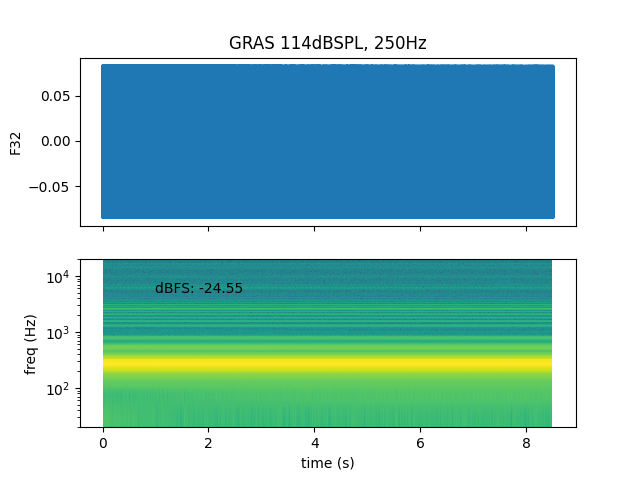

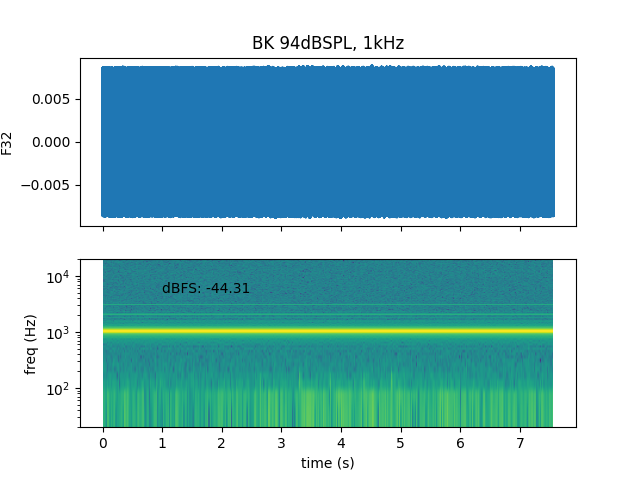

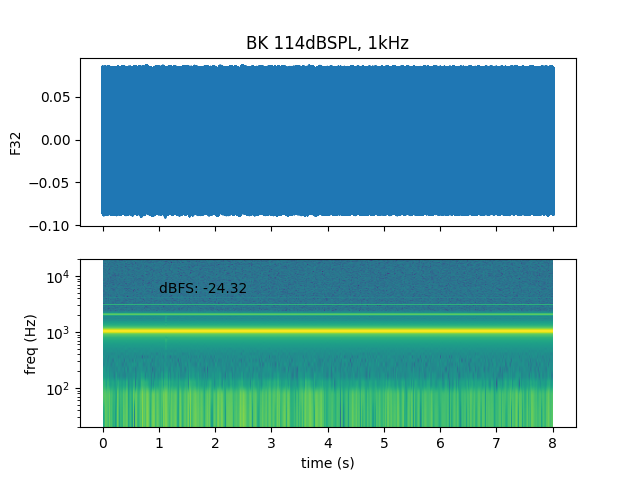

In [211]:
for idx, tmp_data in enumerate(cal_data):
    # plot
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    ax1.plot(tmp_data.time_s, tmp_data.wav_f32)
    ax1.set_ylabel('F32')
    ax1.set_title(tmp_data.trial_name)

    Pxx, freqs, bins, im = ax2.specgram(tmp_data.wav_f32, NFFT=2048, Fs=tmp_data.sample_rate_hz, scale='dB')
    ax2.text( 1, 5000, "dBFS: " + "{:.2f}".format(tmp_data.rms_dBFS) )

    ax2.set_ylim(20, 20000)
    ax2.set_yscale('log')
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('freq (Hz)')

plt.show()


In [205]:
cal_data[0].rms_dBFS

0